Итоговая работа
=====================

Поздравляю вас, теперь вы вооружены знаниями по предобработке данных, и пора применить их на интересном кейсе.

Представлены данные такси, по которым мы должны предсказать возьмёт ли таксист заказ или нет(driver_response).

Принципы вы знаете, чек-лист аналогичен лабораторной работе.

Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

Если возникнут затруднения, то смотрите на материал практических занятий. Данного там должно хватить для выполнения всех пунктов. Желаю успеха!

In [4]:

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [70]:
df = pd.read_csv('C:\DB\yeb.csv')

df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


### Описание датасета

1. 'offer_gk' - уникальный ID сделки,
2. 'weekday_key' - номер дня недели (Воскресенье - 0, Понедельник - 1, и т.д.),
3. 'hour_key' - час (от 0 до 23),
4. 'driver_gk' - уникальный ID водителя,
5. 'order_gk' - уникальный айди заявки,
6. 'driver_latitude' - координаты водителя (широта),
7. 'driver_longitude' - координаты водителя (долгота),
8. 'origin_order_latitude' - координаты пассажира (широта),
9. 'origin_order_longitude' - координаты пассажира (долгота),
10. 'distance_km' - расчётная дистанция поездки (значение -1 значит, что точка назначения не задана),
11. 'duration_min' - расчётное время поездки (значение -1 значит, что точка назначения не задана),
12. 'offer_class_group' - класс заказа,
13. 'ride_type_desc' - тип заказа,
14. 'driver_response' - решение водителя,

#### Поверхностный анализ датасета

##### 1. "driver_gk" и "order_gk"

Значения этих признаков в датасете будут дублироваться. Отклонённую заявку могут взять другие водители, а каждый водитель обычно работает с множеством заявок.

Эти признаки несут ценность следующего характера - они могут выразить индивидуальность каждого пассажира/водителя, но это сделает модель менее абстрактной.

##### 2. "offer_gk"

Этот признак не несёт никакой практической ценности.

Удалить

##### 3. "weekday_key" и "hour_key"

Однозначно, признаки будут оказывать влияние на модель. Т.к. это дискретные величины, то вес каждого значения будет влиять на модель, поэтому его надо будет преобразовать.

Я думаю, что каждое это значение нужно будет ранжировать относительно процента принятых заявок для каждой из величин.

Широта и долгота
Эти значения определенно влияют на модель. Их нужно оставить не тронутыми. Так же из них я получу радиус от водителя до пассажира при заказе.

##### 4. "distance_km" и "duration_min"

Могут быть предзаполены значением (-1), когда пассажир не указывал место назначения. Соответственно, вес отрицательного значения может повлиять на качество модели.

В связи с тем, что эти признаки не возможно предсказать в виду отсутствия данных о результате поездки, наш датасет я разобью на 2 части: 1 - с дистанцией+продолжительностью; 2 - без

##### 5. "offer_class_group"

Класс заказа, с большой долей вероятности влияет на решение взять заказ. Этот признак тоже влияет на модель, его я преобразую как при помощи OneHotEncoder, так и при помоши алгоритма ранжирования, относительно процента успешных ответов.

Категориальный признак

##### 6. "ride_type_desc"

Типа заказа, тоже может влиять на признак успешной сделки. Обработаю аналогично предыдущему признаку.

Категориальный признак

##### 7. "driver_response"

Логический признак, взял водитель заказ или нет. Наше целевое значение

##### Исследование на выбросы

In [7]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()


,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.159860,13.827790,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,2.054222,7.306496,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,5.000000,20.000000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


##### Из таблички выше видно, что есть отсутствующие значения в следующих признаках:

1. 'driver_latitude',
2. ''driver_longitude',
3. ''origin_order_latitude',
4. ''origin_order_longitude',
5. ''distance_km',
6. ''duration_min',

##### Так же есть и зашкаливающие значения для следующих признаков:

1. ''distance_km',
2. ''duration_min',

Если для дистанции и времени поездки отсутствующие значения появились понятно почему, то для координат не понятно, почему такое могло произойти. Исследую сперва кол-во отсутствующих координат:

In [8]:
df[df['driver_latitude'] == -1].shape, df[df['driver_longitude'] == -1].shape


((140, 14), (140, 14))

In [9]:

driver_lat_indexes = df[df['driver_latitude'] == -1].index
driver_lon_indexes = df[df['driver_longitude'] == -1].index

False in (driver_lat_indexes == driver_lon_indexes)

False

In [10]:
df[df['origin_order_latitude'] == -1].shape, df[df['origin_order_longitude'] == -1].shape


((13, 14), (13, 14))

In [11]:
origin_lat_indexes = df[df['origin_order_latitude'] == -1].index
origin_lon_indexes = df[df['origin_order_longitude'] == -1].index

False in (origin_lat_indexes == origin_lon_indexes)

False

Окей, кол-во записей с битыми координатами для водителей и пассажиров отличается. К счатью индексы для долготы и широты двух срезов совпадают, а это значит, что нет отсутстующего только одного признака у записи

Думаю, от этих записей можно избавиться, т.к. их количество составляет меньге 0.2% от всех записей

In [12]:
df.drop([*driver_lat_indexes, *origin_lat_indexes], inplace=True)

In [13]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000
mean,3.160055,13.826635,55.780324,37.546255,55.780191,37.546314,18.412009,23.159354,0.491752
std,2.054491,7.308412,0.234164,0.196938,0.156110,0.159890,41.150741,33.901250,0.499934
min,0.000000,0.000000,0.000000,0.000000,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709284,37.413497,55.708502,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773079,37.533872,55.772731,37.532191,10.442000,19.750000,0.000000
75%,5.000000,20.000000,55.960696,37.624235,55.962035,37.624145,30.695000,37.883000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,5234.283000,3958.283000,1.000000


В координатах водителя есть ещё один выброс, точнее, нулевое значение. От него тоже избавимся

In [14]:
df[df['driver_latitude'] == 0].shape, df[df['driver_longitude'] == 0].shape

((1, 14), (1, 14))

In [15]:
driver_zero_lat_indexes = df[df['driver_latitude'] == 0].index
driver_zero_lon_indexes = df[df['driver_longitude'] == 0].index

False in (driver_lat_indexes == driver_lon_indexes)

False

In [16]:
df.drop([*driver_zero_lat_indexes], inplace=True)


In [17]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000
mean,3.160087,13.826633,55.780883,37.546631,55.780195,37.546311,18.411756,23.159030,0.491757
std,2.054477,7.308449,0.153851,0.157053,0.156106,0.159887,41.150869,33.901266,0.499935
min,0.000000,0.000000,55.327636,36.984771,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709285,37.413497,55.708502,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773085,37.533874,55.772734,37.532189,10.441500,19.750000,0.000000
75%,5.000000,20.000000,55.960697,37.624235,55.962035,37.624145,30.694750,37.883000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,5234.283000,3958.283000,1.000000


Теперь в датасете признаки координатов и водителя, и пассажира не содержат выбросов.

Теперь посмотрим, сколько отсутствующих значений в признаках 'distance_km' и 'duration_min'

In [18]:
df[df['distance_km'] == -1].shape, df[df['duration_min'] == -1].shape

((26083, 14), (26083, 14))

In [19]:
False in (df[df['distance_km'] == -1].index == df[df['duration_min'] == -1].index)

False

Отсутствующих значений много, индексы признаков дистанции и продолжительности совпадают. Определенно из этих записей нужно будет делать отдельный датасет и предсказывать целевое значение для двух ситуаций - когда пункт назначения известен и когда не известен.

Проверим, есть ли нулевые значения в этих признаках

In [20]:
df[df['distance_km'] == 0].shape, df[df['duration_min'] == 0].shape

((152, 14), (152, 14))

In [21]:
distance_km_zero_indexes = df[df['distance_km'] == 0].index
duration_min_zero_indexes = df[df['duration_min'] == 0].index

False in (distance_km_zero_indexes == duration_min_zero_indexes)

False

Нулевых значений не много и индексы дистанции совпадают с индексами продолжительности. Думаю, от них тоже можно избавиться без особого ущерба для наших данных

In [22]:
df.drop([*distance_km_zero_indexes], inplace=True)

In [23]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99694.000000,99694.000000,99694.000000,99694.000000,99694.000000,99694.000000,99694.000000,99694.000000,99694.000000
mean,3.160200,13.829057,55.780892,37.546583,55.780203,37.546266,18.439828,23.194340,0.491765
std,2.054376,7.307393,0.153854,0.157035,0.156108,0.159867,41.175943,33.915028,0.499935
min,0.000000,0.000000,55.327636,36.984771,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709286,37.413497,55.708502,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773095,37.533859,55.772737,37.532150,10.473500,19.791500,0.000000
75%,5.000000,20.000000,55.960702,37.624205,55.962035,37.624094,30.733500,37.917000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,5234.283000,3958.283000,1.000000


Теперь я хотел бы посмотреть, что это за поездка такая была не 5 тысяч километров и сколько было подобных поездок в общем в датасете

In [24]:
df[df['distance_km'] > 250].shape

(63, 14)

Вполне вероятно, что здесь нет никакой ошибки и были действительно дальние поездки, но нам эти записи будут мешать обучать модель. Записи, где километраж был больше 250км я удалю

In [25]:
df.drop(df[df['distance_km'] > 250].index, inplace=True)

In [26]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99631.000000,99631.000000,99631.000000,99631.000000,99631.000000,99631.000000,99631.000000,99631.000000,99631.000000
mean,3.159900,13.828216,55.780960,37.546524,55.780272,37.546205,17.824492,22.734539,0.491634
std,2.054442,7.307877,0.153822,0.156998,0.156074,0.159826,20.376904,20.815011,0.499933
min,0.000000,0.000000,55.327636,36.984771,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709304,37.413497,55.708573,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773157,37.533813,55.772761,37.532104,10.463000,19.767000,0.000000
75%,5.000000,20.000000,55.960729,37.624140,55.962046,37.623953,30.679000,37.883000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,246.137000,199.267000,1.000000


##### Итог: Удалось отчистить данные от явных выбросов или битых данных, при этом не нанеся особого ущерба остальному датасету. Теперь можно приступить к генерации новых признаков.

##### Генерация новых признаков

Перед тем, как заняться генерированием новых признаков, я изучу возможные категориальные значения

In [27]:
df['offer_class_group'].unique()

array(['Economy', 'Standard', 'XL', 'Kids', 'Delivery', 'Test', 'Premium',
       'VIP', 'VIP+'], dtype=object)

In [28]:
df['ride_type_desc'].unique()

array(['private', 'business', 'affiliate', 'SMB'], dtype=object)

Как видно из возможных значений наших категориальных признаков, количество полученных из них новых категорий вполне приемлемо.

Так же, я заметил, что есть такой класс поездки, как 'Test'. Я уверен, от него нужно избавиться.

In [29]:
df = df[df['offer_class_group'] != 'Test']

df.reset_index(drop=True).shape

(99623, 14)

Удалённых значений получилось не много

Можно приступать к генерации новых признаков


In [64]:
def calc_vector_len(row):
    """
    Фнукция принимает ряд из датасета и считает рассточние между позицией водителя
    и позицией клиента в момент заказа такси.
    """
    return np.linalg.norm([
        row['driver_latitude'] - row['origin_order_latitude'],
        row['driver_longitude'] - row['origin_order_longitude'],
    ])

In [75]:
df['driver_origin_distance'] = df.apply(calc_vector_len, axis=1)


In [76]:
df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,driver_origin_distance
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,0.020890
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,0.050597
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,0.006442
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,0.009697
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,0.010694


Так же, в изначальный датасет я добавлю категориальные признаки при помощи OneHotEncoding подхода



In [83]:
df = pd.get_dummies(df)

df.columns

Index(['offer_gk', 'weekday_key', 'hour_key', 'driver_gk', 'order_gk',
       'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'driver_response', 'driver_origin_distance',
       'offer_class_group_Delivery', 'offer_class_group_Economy',
       'offer_class_group_Kids', 'offer_class_group_Premium',
       'offer_class_group_Standard', 'offer_class_group_Test',
       'offer_class_group_VIP', 'offer_class_group_VIP+',
       'offer_class_group_XL', 'ride_type_desc_SMB',
       'ride_type_desc_affiliate', 'ride_type_desc_business',
       'ride_type_desc_private'],
      dtype='object')


Сразу оговорюсь, я добавил действительно очень много новых признаков, это мне нужно для дальнейших эксперементов и выявления наиболее оптимальной стратегии обучения

Сейчас я хочу сразу же совладать с нашими многочисленными признаками и сгруппирую их названия по категориям

In [109]:
col_names = {
    'ids': ['offer_gk', 'driver_gk', 'order_gk'],
    
    'time_keys': ['weekday_key', 'hour_key'],
    
    'coords': ['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'],
    
    'dest': ['distance_km', 'duration_min'],
    
    'time_rank': ['time_rank'],
    
    'offer_class_rank': ['offer_class_group_rank'],
    
    'ride_type_rank': ['ride_type_desc_rank'],
    
    'weekday_key_rank': ['weekday_key_rank'],
    
    'hour_key_rank': ['hour_key_rank'],
    
    'driver_origin_distance': ['driver_origin_distance'],
    
    'offer_class_features': [
        'offer_class_group_Delivery',
        'offer_class_group_Economy',
        'offer_class_group_Kids',
        'offer_class_group_Premium',
        'offer_class_group_Standard',
        'offer_class_group_VIP',
        'offer_class_group_VIP+',
        'offer_class_group_XL'
    ],
    
    'ride_type_features': [
        'ride_type_desc_SMB',
        'ride_type_desc_affiliate',
        'ride_type_desc_business',
        'ride_type_desc_private',
    ],    
    
    'target_value': ['driver_response'],
}

Изучение влияния данных друг на друга
Тут я тоже оговорюсь, изначально я планировал разбить датасет на две части - с известным пунктом назначения и без.

Сейчас самое время

In [117]:
df_with_dest = df[df[col_names['dest'][0]] != -1]
df_without_dest = df[df[col_names['dest'][0]] == -1].drop([*col_names['dest']], axis=1)

In [118]:
df_with_dest.shape, df_without_dest.shape

((73793, 26), (26207, 24))

Отлично, теперь можно составить матрицы корреляций. Я сделаю это при помощи карты теплоты и модуля seaborn

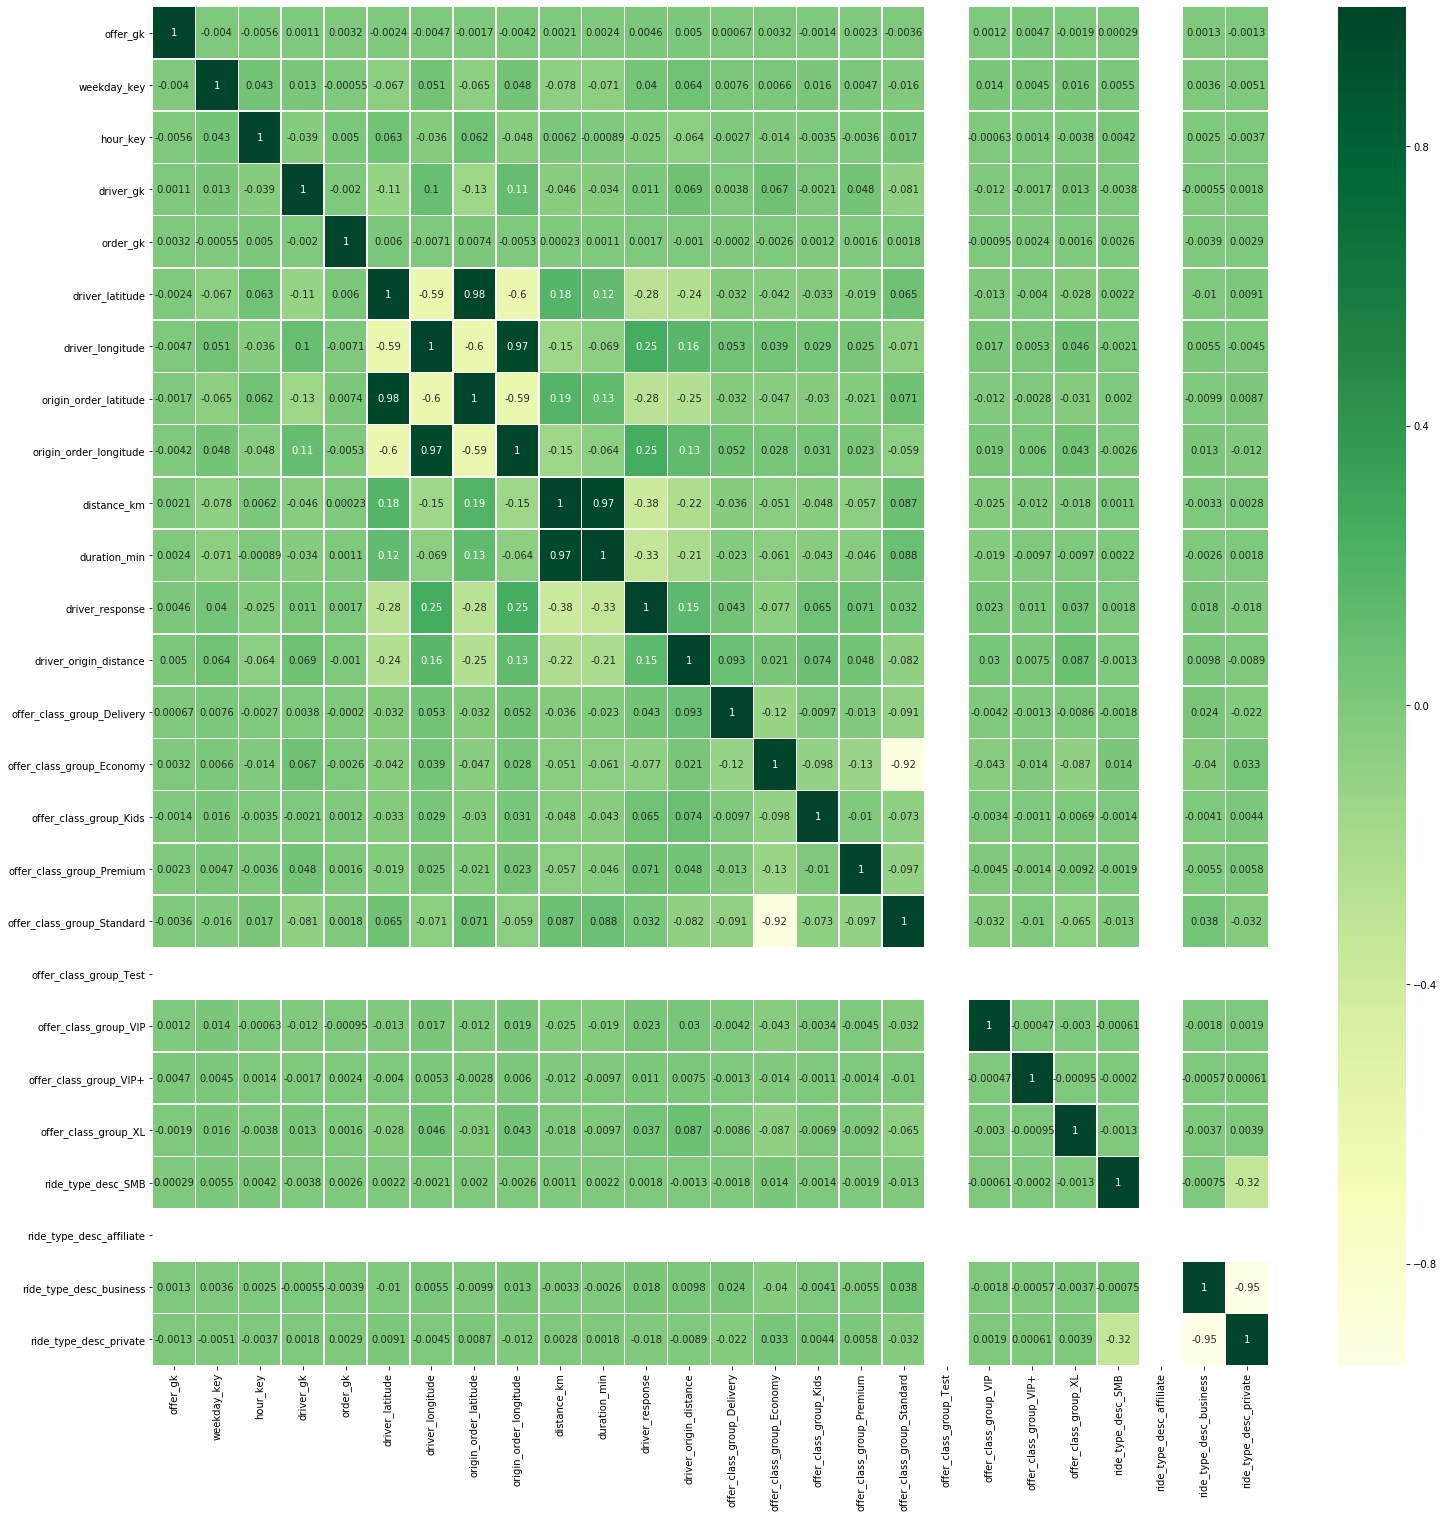

In [114]:
plt.figure(figsize=(25, 25))

sns.heatmap(df_with_dest.corr(method='spearman'), annot=True, linewidths=0.5, cmap='YlGn')
plt.show()

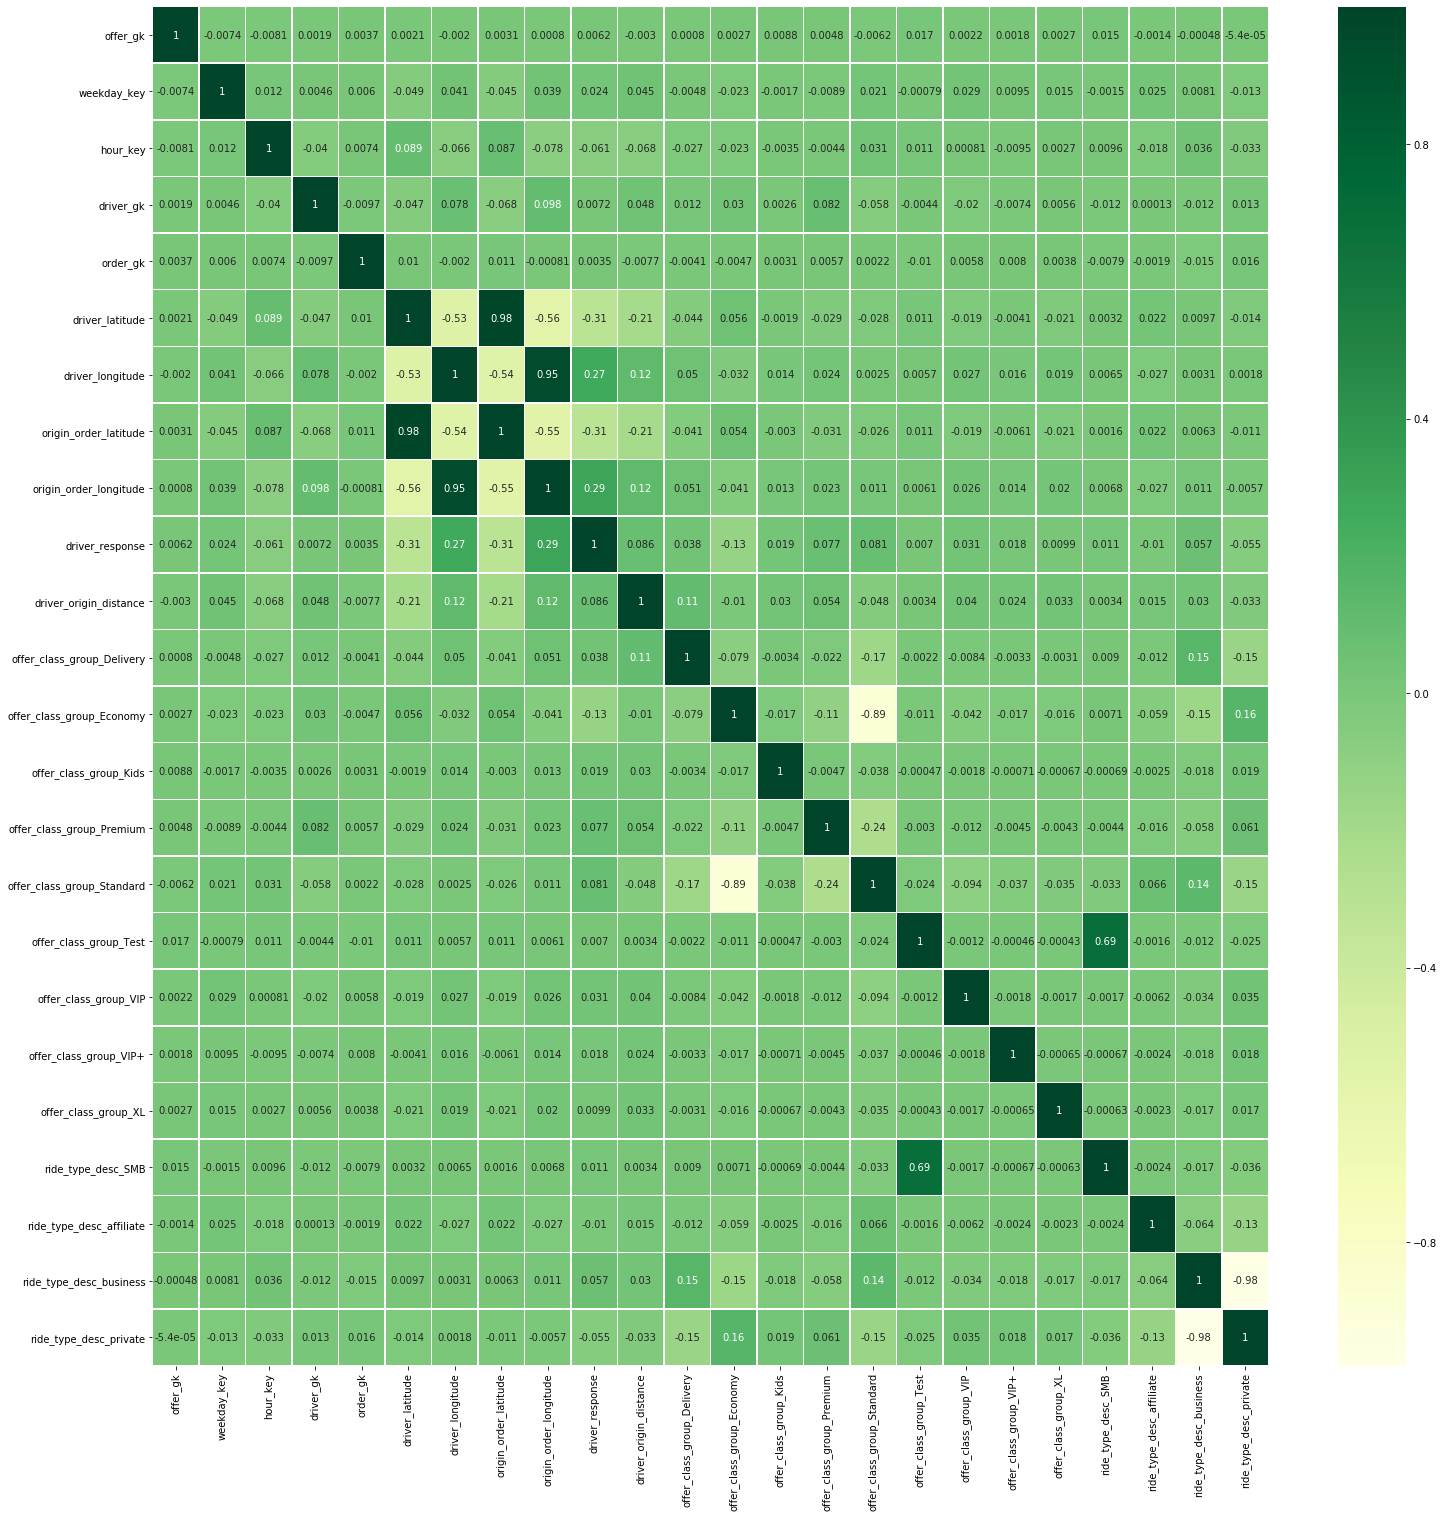

In [113]:
plt.figure(figsize=(25, 25))

sns.heatmap(df_without_dest.corr(method='spearman'), annot=True, linewidths=0.5, cmap='YlGn')
plt.show()

Рисовать такие большие heatmaps было не особо полезно, но по ним я вижу, что целевой признак особо не коррелирует ни с одним из других признаков

Так же, я вижу, что высокую корреляцию между собой имеют следующие признаки:

время и дистанция поездки;
широта из координат водителя и клиента;
долгота из координат водителя и клиента;
ранг поездки и бизнес тип поездки
час и временной ранг;
Это говорит нам о том, что с использование именно этих признаков сможет сильно повлиять на мою модель

Модели с известной точкой назначения

In [89]:
rfc = RandomForestClassifier(n_estimators=100)

Сперва проверим, какой результат получится, если взять все признаки

In [104]:
X_data = df_with_dest[[
    *col_names['time_keys'],
    *col_names['coords'],
    *col_names['dest'],
    *col_names['driver_origin_distance'],
    *col_names['offer_class_features'],
    *col_names['ride_type_features'],
]]

Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()
Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.7340412057723263


Сейчас я оставлю меньше категориальных признаков, сделаю одну модель с фичами

In [116]:
# Только с фичами
X_data = df_with_dest[[
    *col_names['driver_origin_distance'],
    *col_names['offer_class_features'],
    *col_names['ride_type_features'],
]]

Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.5474233840560279

Проверим, что получится, если оставить только остальные признаки, убрав ранги и фичи

In [123]:
X_data = df_with_dest[[
    *col_names['time_keys'],
    *col_names['coords'],
    *col_names['dest'],
]]

Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.7221566526129928

Удивительно, но результат сильно возрос. Это означает, что многие из сгенерированных новых признаков были созданы зря...

На этапе анализа зависимости данных я выяснил, что мы имеем некоторые зависимости одних данных от других. Попробую сыграть на этом и обучу ещё одну модель

In [124]:
X_data = df_with_dest[[
    *col_names['coords'],
    *col_names['dest'],
]]

Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.7086325799128435

Итого: максимальный результат, которого мне удалось добиться ~73% точности, при этом, на полном объёме данных без снижения признаков.

Модели с неизвестной точкой назначения
Проверки будут идти по тому же сценарию

Сперва проверим, какой результат получится, если взять все признаки

In [128]:
X_data = df_without_dest[[
    *col_names['time_keys'],
    *col_names['coords'],
    *col_names['driver_origin_distance'],
    *col_names['offer_class_features'],
    *col_names['ride_type_features'],
]]


Y_data = df_without_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.7565576135255478

Сейчас я оставлю меньше категориальных признаков, проверю модель с фичами

In [130]:
# Только с фичами
X_data = df_without_dest[[
    *col_names['driver_origin_distance'],
    *col_names['offer_class_features'],
    *col_names['ride_type_features'],
]]

Y_data = df_without_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
S:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.5621400364518842

Результат практически не отличается от предыдущего исследования для датасета с имеющейся точкой назначения

Заключение
Перед началом построения модели я встал перед дилемой - какую модель выбрать?

Т.к. мы определяем категориальный признак, то я подумал, что линейная регрессия тут не подойдёт, поэтому взялся за построение случайных лесов.

Перед оптимизацией. Я думал на счёт нормирования, но это подразумевает нормирование категориальных признаков, либо частичное нормирование. Для меня невозможно представить, как так будет получаться, что мы учим модель на нормированных данных, а потом будем подавать ненормированные данные...

Поэтому результат получился такой слабенький ~ 75%...